# MMC Laboratorium 6

Autor: Jakub Ostrzołek

## Zadanie 1

### Funkcje ładujące wyniki działania programu `epidemia`

In [20]:
import numpy as np
from dataclasses import dataclass
from typing import TextIO

BINARY = "./out/ising"


@dataclass
class ExperimentResult:
    system_energy_mean: float
    ghost_energy_mean: float
    magnetization_mean: float
    temperature: float


def parse_experiment_result(output: TextIO) -> ExperimentResult:
    lines = [line for line in output.readlines() if "=" in line]
    values = [line.split("=")[1].strip() for line in lines]
    return ExperimentResult(*map(float, values))

### Funkcja uruchamiająca program `epidemia`

Zmodyfikowałem program `epidemia` tak, żeby przyjmował swoje parametry poprzez argumenty wywołania linii poleceń.

In [21]:
from subprocess import run
from io import StringIO


def run_experiment(
    side: int = 10,
    energy: int = -184,
    steps: int = 1000,
) -> ExperimentResult:
    command = [
        BINARY,
        "--bok-mapy", str(side),
        "--energia", str(energy),
        "--liczba-krokow", str(steps),
    ]

    process = run(command, capture_output=True, encoding="UTF-8")
    process.check_returncode()

    out_buffer = StringIO(process.stdout)
    return parse_experiment_result(out_buffer)

### Wywołanie programu z domyślnymi parametrami

In [22]:
result = run_experiment()
result

ExperimentResult(system_energy_mean=-184.28, ghost_energy_mean=0.28, magnetization_mean=0.95714, temperature=1.46686)

In [23]:
sides = [10, 20, 40]

energy_sets = [
    np.linspace(-184, -24, 8, dtype=int),
    np.linspace(-768, -32, 32, dtype=int),
    np.linspace(-3072, -128, 128, dtype=int),
]

result_sets = [
    [run_experiment(side=side, energy=energy) for energy in energies]
    for energies, side in zip(energy_sets, sides)
]

### Funkcje wizualizacji wyników działania programu `epidemia`

Funkcja `show_map` wyświetla mapę końcowego rozkładu osób o odpowiednich statusach.

Funkcja `show_sequences` wyświetla jedną ze statystyk czasowych przebiegu eksperymentu, poprzez wykreślenie linii dla każdego eksperymentu w ramach serii. Oprócz tego zaznacza linią przerywaną 5-ty percentyl wartości statystyki z końca przebiegów eksperymentów w serii.

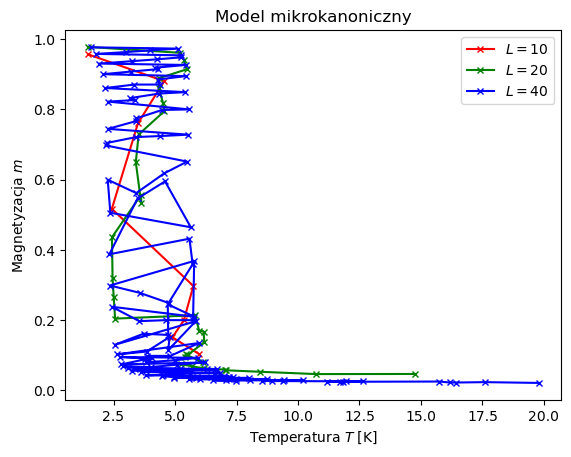

In [25]:
from matplotlib import pyplot as plt

colors = ["r", "g", "b"]

for results, side, color in zip(result_sets, sides, colors):
    xs = [result.temperature for result in results]
    ys = [result.magnetization_mean for result in results]

    plt.plot(xs, ys, f"{color}x-", markersize=5, label=f"$L={side}$")
    plt.xlabel("Temperatura $T$ [K]")
    plt.ylabel("Magnetyzacja $m$")
    plt.title("Model mikrokanoniczny")

plt.legend()
plt.show()

## Zadanie 2